In [1]:
# setup shits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
femur_raw = pd.read_csv('xsens_quaternion/long_pause_5sets/femur.csv', skiprows=10)
tibia_raw = pd.read_csv('xsens_quaternion/long_pause_5sets/tibia.csv', skiprows=10)
femur_raw.columns = [i+"_femur" for i in femur_raw.columns]
tibia_raw.columns = [i+"_tibia" for i in tibia_raw.columns]
print(femur_raw.columns)

Index(['PacketCounter_femur', 'SampleTimeFine_femur', 'Quat_W_femur',
       'Quat_X_femur', 'Quat_Y_femur', 'Quat_Z_femur', 'FreeAcc_X_femur',
       'FreeAcc_Y_femur', 'FreeAcc_Z_femur'],
      dtype='object')


In [3]:
combined_raw = femur_raw.merge(tibia_raw, how='outer', left_on='SampleTimeFine_femur', right_on='SampleTimeFine_tibia')
# print(combined_raw.head(40))
print(combined_raw.tail(1))
combined_raw.dropna(inplace=True)
print(combined_raw.tail(1))
combined_raw.to_csv('./xsens_quaternion/long_pause_5sets/combined_raw.csv', index=False)

      PacketCounter_femur  SampleTimeFine_femur  Quat_W_femur  Quat_X_femur  \
2711                  NaN                   NaN           NaN           NaN   

      Quat_Y_femur  Quat_Z_femur  FreeAcc_X_femur  FreeAcc_Y_femur  \
2711           NaN           NaN              NaN              NaN   

      FreeAcc_Z_femur  PacketCounter_tibia  SampleTimeFine_tibia  \
2711              NaN                    1             910110189   

      Quat_W_tibia  Quat_X_tibia  Quat_Y_tibia  Quat_Z_tibia  FreeAcc_X_tibia  \
2711      0.587359      0.075036     -0.798655     -0.107372         0.014197   

      FreeAcc_Y_tibia  FreeAcc_Z_tibia  
2711         0.003597          0.11954  
      PacketCounter_femur  SampleTimeFine_femur  Quat_W_femur  Quat_X_femur  \
2710               2711.0           955294426.0     -0.256131     -0.696556   

      Quat_Y_femur  Quat_Z_femur  FreeAcc_X_femur  FreeAcc_Y_femur  \
2710      0.288249     -0.605077         0.013788         0.089697   

      FreeAcc_Z_fe

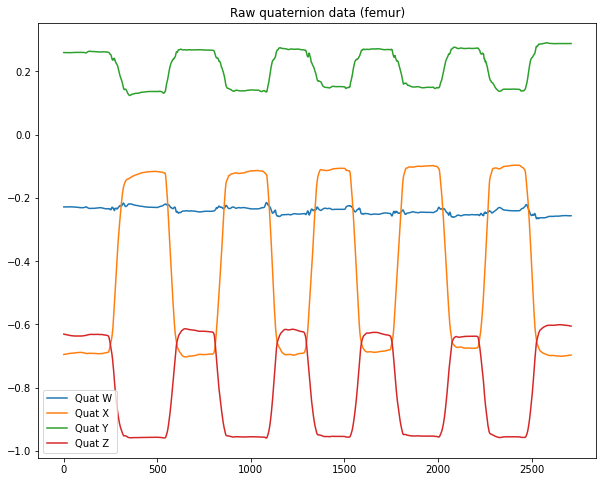

In [4]:
plt.plot(combined_raw['PacketCounter_femur'], combined_raw['Quat_W_femur'], label = 'Quat W')
plt.plot(combined_raw['PacketCounter_femur'], combined_raw['Quat_X_femur'], label = 'Quat X')
plt.plot(combined_raw['PacketCounter_femur'], combined_raw['Quat_Y_femur'], label = 'Quat Y')
plt.plot(combined_raw['PacketCounter_femur'], combined_raw['Quat_Z_femur'], label = 'Quat Z')
plt.title("Raw quaternion data (femur)")
plt.legend()

plt.savefig('./xsens_quaternion/long_pause_5sets/raw_data.png')
plt.show()

'Useless': QuatW

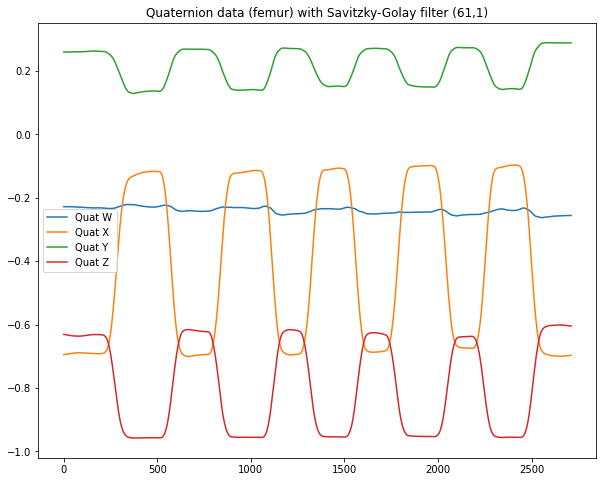

In [5]:
from scipy.signal import savgol_filter

combined_filter = combined_raw.copy()

for i in combined_filter.columns:
    combined_filter[i] = savgol_filter(combined_filter[i], 61, 1)

plt.plot(combined_filter['PacketCounter_femur'], combined_filter['Quat_W_femur'], label = 'Quat W')
plt.plot(combined_filter['PacketCounter_femur'], combined_filter['Quat_X_femur'], label = 'Quat X')
plt.plot(combined_filter['PacketCounter_femur'], combined_filter['Quat_Y_femur'], label = 'Quat Y')
plt.plot(combined_filter['PacketCounter_femur'], combined_filter['Quat_Z_femur'], label = 'Quat Z')
plt.title("Quaternion data (femur) with Savitzky-Golay filter (61,1)")
plt.legend()
plt.savefig('./xsens_quaternion/long_pause_5sets/savgol.png')
plt.show()

In [6]:
test_col = combined_filter['Quat_X_femur']
baseline = np.mean(test_col[0:30])
baseline_upper = baseline + 0.05 #arbitrary margin, might change later
baseline_lower = baseline - 0.05

upcross_pts_X = []
downcross_pts_X = []

for i, val in enumerate(test_col[:-1]):
    if test_col[i+1] > baseline_upper and test_col[i] < baseline_upper:
        upcross_pts_X.append(i)
    elif test_col[i+1] < baseline_upper and test_col[i] > baseline_upper:
        downcross_pts_X.append(i)

print(upcross_pts_X)
print(downcross_pts_X)

[245, 802, 1288, 1745, 2211]
[608, 1148, 1596, 2083, 2534]


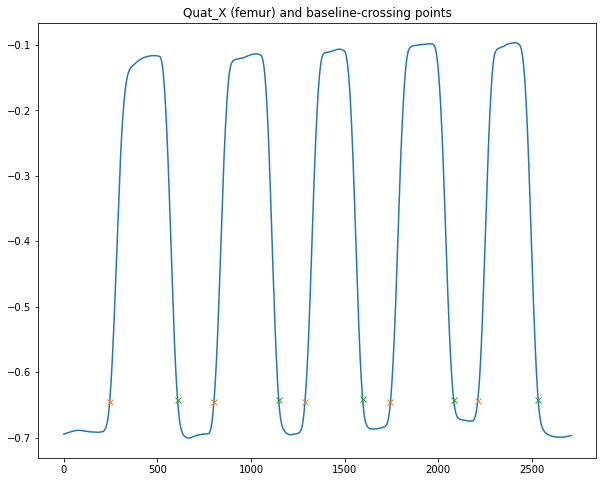

In [7]:
plt.plot(test_col)

plt.plot(upcross_pts_X, test_col[upcross_pts_X], "x")
plt.plot(downcross_pts_X, test_col[downcross_pts_X], "x")
plt.title("Quat_X (femur) and baseline-crossing points")
plt.savefig("./xsens_quaternion/long_pause_5sets/crossings.png")

plt.show()

In [8]:
# spaghetti shit, might wanna fix later
# bottom_start: means that the 'resting' state (i.e. standing) is at lower value than 'engaged' state (i.e. squat)
# of the exercise, for that particular sensor reading alone

reps_active = []
reps_rest = []

if (upcross_pts_X[0] < downcross_pts_X[0]):
    bottom_start = True
else:
    bottom_start = False

if bottom_start:
    for i, val in enumerate(upcross_pts_X):
        reps_active.append([upcross_pts_X[i], downcross_pts_X[i]])
        if i != 0:
            reps_rest.append([downcross_pts_X[i-1], upcross_pts_X[i]])
            
print(reps_active)
print(reps_rest)

[[245, 608], [802, 1148], [1288, 1596], [1745, 2083], [2211, 2534]]
[[608, 802], [1148, 1288], [1596, 1745], [2083, 2211]]


In [9]:
# this time is NOT accurate
# later use unix time stamps instead

print("Active periods:")
for i, val in enumerate(reps_active):
    print("{}: ".format(i+1) + "%.3f to %.3f" % (val[0]/60, val[1]/60))

print("Rest periods: ")
for i, val in enumerate(reps_rest):
    print("{}: ".format(i+1) + "%.3f to %.3f" % (val[0]/60, val[1]/60))


Active periods:
1: 4.083 to 10.133
2: 13.367 to 19.133
3: 21.467 to 26.600
4: 29.083 to 34.717
5: 36.850 to 42.233
Rest periods: 
1: 10.133 to 13.367
2: 19.133 to 21.467
3: 26.600 to 29.083
4: 34.717 to 36.850
